In [1]:
# Load Libaries Needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import category_encoders as ce

In [2]:
X_train=pd.read_csv('X_train.csv',index_col='Rank')
X_test=pd.read_csv('X_test.csv',index_col='Rank')
y_train=pd.read_csv('y_train.csv',index_col='Rank')
y_test=pd.read_csv('y_test.csv',index_col='Rank')

In [3]:
# Cat Boost Encoding 
cat_features= ['Genre', 'Publisher','Device']       
target_enc = ce.CatBoostEncoder(cols=cat_features)
target_enc.fit(X_train[cat_features], y_train['Global_Sales'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train_TE = X_train.join(target_enc.transform(X_train[cat_features]).add_suffix('_target'))
test_TE = X_test.join(target_enc.transform(X_test[cat_features]).add_suffix('_target'))

/Users/shailmirpuri/opt/anaconda3/envs/vgsales_predict/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [4]:
X_train=train_TE.drop(columns=cat_features)
X_test=test_TE.drop(columns=cat_features)

In [5]:
y_train=np.reshape(y_train.values,len(y_train))
y_test=np.reshape(y_test.values,len(y_test))

In [6]:
bool_features=['FIFA', 'Mario', 'Call of Duty', 'Grand Theft Auto', 'Pokemon', 'Halo',
       'Wii', 'NBA']
num_features=['Year','NA_Sales As a percentage of Total',
       'EU_Sales As a percentage of Total',
       'JP_Sales As a percentage of Total',
       'Other_Sales As a percentage of Total','Genre_target','Publisher_target','Device_target']

In [7]:
# Create Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),('normalize',MinMaxScaler())])
bool_transformer=SimpleImputer(strategy='constant')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),('bool',bool_transformer,bool_features)])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.9 = 0.22

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
def score(model):
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    my_pipeline.fit(X_train,y_train)
    pred=my_pipeline.predict(X_val)
    MAE=mean_absolute_error(pred,y_val)
    print(MAE)

In [27]:
# Feature Importance 
from sklearn.ensemble import ExtraTreesRegressor
model=ExtraTreesRegressor()
score(model)

0.32935074063286107


<AxesSubplot:>

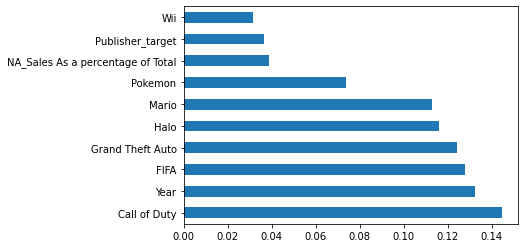

In [38]:
important_features=pd.Series(model.feature_importances_,index=X_train.columns)
important_features.nlargest(10).plot(kind='barh')

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
rf=RandomForestRegressor(random_state=1)
score(rf)

0.3284777370128015


In [17]:
for i in [100,500,1000]:
    rf=RandomForestRegressor(n_estimators=i,random_state=1)
    score(rf)

0.3284777370128015
0.3269346264136695
0.32658563637839827


In [19]:
for i in ['auto', 'sqrt', 'log2']:
    rf=RandomForestRegressor(n_estimators=1000,max_features=i )
    score(rf)

0.3266339336301435
0.32370971836609586
0.32403186855986227


In [20]:
for i in [True,False]:
    rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt', bootstrap = i)
    score(rf)

0.3240200153974452
0.31758769729124076


In [21]:
for i in [10,40,60,80,100]:
    rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt', bootstrap = False,max_depth =i)
    score(rf)

0.36938603057309594
0.31676547508364766
0.31773073297046556
0.31681986771260884
0.3167119553138073


In [22]:
for i in [2, 5, 10]:
    rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt', bootstrap = False,max_depth=100,min_samples_split =i)
    score(rf)

0.31733222981498654
0.3203917993885187
0.32337624096009604


In [23]:
for i in [1, 2, 4,6,8,10]:
    rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt', bootstrap = False,max_depth=100,min_samples_split =2,min_samples_leaf = i)
    score(rf)

0.3171386183787655
0.32322284850227895
0.3311527654887186
0.34067415050792543
0.3466303398710195
0.3529233945197684


In [24]:
for i in range(600,1001,100):
    rf=RandomForestRegressor(n_estimators=i,max_features='sqrt', bootstrap = False,
                              max_depth=100,min_samples_split =2,min_samples_leaf = 1,random_state=1)
    score(rf)

0.3170920445256811
0.31710024844187507
0.31704132056369566
0.31709309057584306
0.31686486303994993


In [26]:
# The best hyperparameters 
best_rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt', bootstrap = False,
                              max_depth=100,min_samples_split =2,min_samples_leaf = 1,random_state=1)

In [ ]:
# Finally let's train the final 